# Viterbi

In [43]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
data = pd.read_csv("../data/hulls_df_compact_matchday1.csv")
data = data.dropna()
data.head()

,Time [s],Period,HomeHull,AwayHull
0,2.0,1.0,561.031976,1195.207383
1,3.0,1.0,496.093264,1115.390332
2,4.0,1.0,466.225606,1083.424411
3,5.0,1.0,503.593453,1105.121644
4,6.0,1.0,563.030125,1132.199093


## Univariate Model

In [27]:
def gamma_viterbi_decoder(data, transition_matrix, shape_params, rate_params):
    """
    Performs Viterbi decoding for a Gamma HMM.

    Parameters:
    data (list or array): The observations.
    hidden_dim (int): Number of hidden states.
    transition_matrix (torch.Tensor): The state transition probabilities.
    shape_params (torch.Tensor): The shape parameters of the Gamma distributions.
    rate_params (torch.Tensor): The rate parameters of the Gamma distributions.

    Returns:
    list: The most likely sequence of hidden states.
    """
    hidden_dim= len(shape_params)
    states = [np.random.randint(low=0,high=hidden_dim)]
    for t in pyro.markov(range(len(data))):
        states.append(pyro.sample("states_{}".format(t),
                                  dist.Categorical(transition_matrix[states[-1]])))
        pyro.sample("obs_{}".format(t),
                    dist.Gamma(shape_params[states[-1]], rate_params[states[-1]]),
                    obs=data[t])
    return states[1:]  # returns the most likely states

### Home Hull

In [28]:
x_sequence = torch.tensor(data["HomeHull"].values)

In [29]:
posterior=torch.load("parameters/singleHMM_home.pt")
posterior

{'probs_x': tensor([[0.9631, 0.0369],
         [0.0634, 0.9366]], requires_grad=True),
 'probs_alpha': tensor([  5.5652, 120.9643], requires_grad=True),
 'probs_beta': tensor([0.0063, 0.1008], requires_grad=True)}

In [30]:
transition_matrix = torch.tensor([[0.9631, 0.0369],
                                  [0.0634, 0.9366]])
shape_params = torch.tensor([ 5.5652, 120.9643])  
rate_params = torch.tensor([0.0063, 0.1008]) 

hidden_states = gamma_viterbi_decoder(x_sequence, transition_matrix=transition_matrix, shape_params=shape_params, rate_params=rate_params)

In [31]:
most_likely_states_H = np.array([int(state) for state in hidden_states])
data["HomeMLS"]=most_likely_states_H

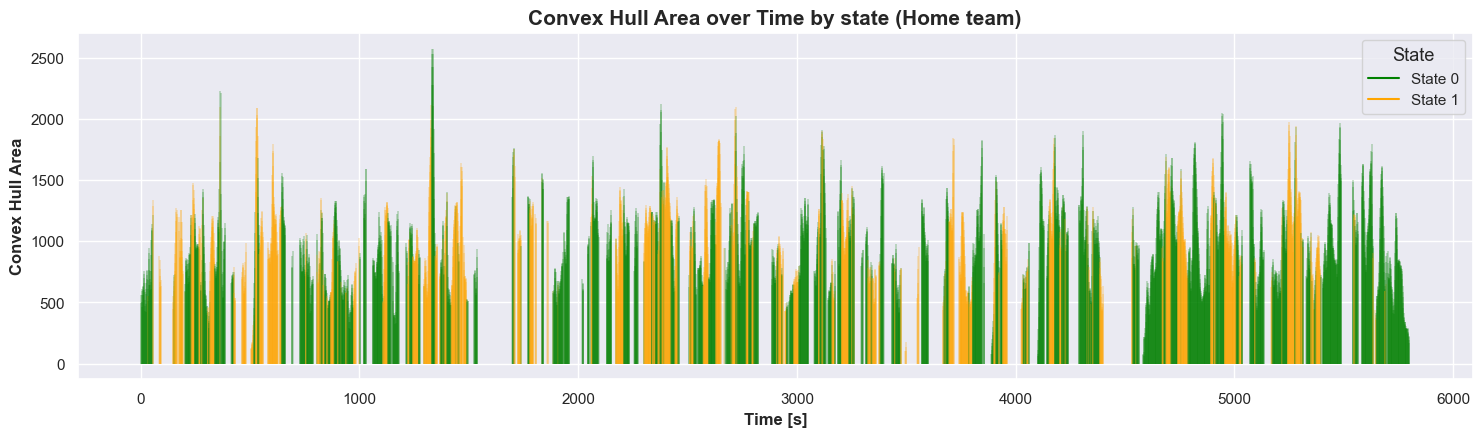

In [32]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['HomeMLS'].map(class_colors)

plt.figure(figsize=(18, 4.5))
plt.vlines(data["Time [s]"], ymin=0, ymax=data["HomeHull"], color=colors,linewidth=0.3)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time by state (Home team)", fontsize=15, fontweight='bold');

# Creating legend manually since automatic legend does not work well with vlines
for i, state in enumerate([0,1]):
    plt.plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')

plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper right');
plt.savefig("../plots/UnivariateHMM_MostLikelySeq_HomeTeam_matchday1.png",dpi=350)

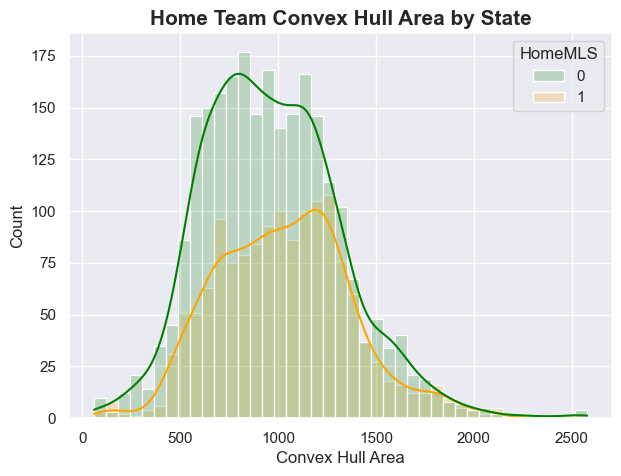

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Home Team Convex Hull Area by State", fontsize=15, fontweight='bold');
fig.savefig("../plots/UnivariateHMM_StateDistribution_HomeTeam_matchday1.png",dpi=350)

### Away Hull

In [34]:
y_sequence = torch.tensor(data["AwayHull"].values)

In [35]:
posterior=torch.load("parameters/singleHMM_away.pt")
posterior

{'probs_x': tensor([[0.9672, 0.0328],
         [0.0506, 0.9494]], requires_grad=True),
 'probs_alpha': tensor([ 6.5119, 35.4986], requires_grad=True),
 'probs_beta': tensor([0.0058, 0.0493], requires_grad=True)}

In [36]:
transition_matrix = torch.tensor([[0.9672, 0.0328],
                                  [0.0506, 0.9494]])
shape_params = torch.tensor([ 6.5119, 35.4986])  
rate_params = torch.tensor([0.0058, 0.0493]) 

hidden_states = gamma_viterbi_decoder(x_sequence, transition_matrix=transition_matrix, shape_params=shape_params, rate_params=rate_params)

In [37]:
most_likely_states_A = np.array([int(state) for state in hidden_states])
data["AwayMLS"]=most_likely_states_A

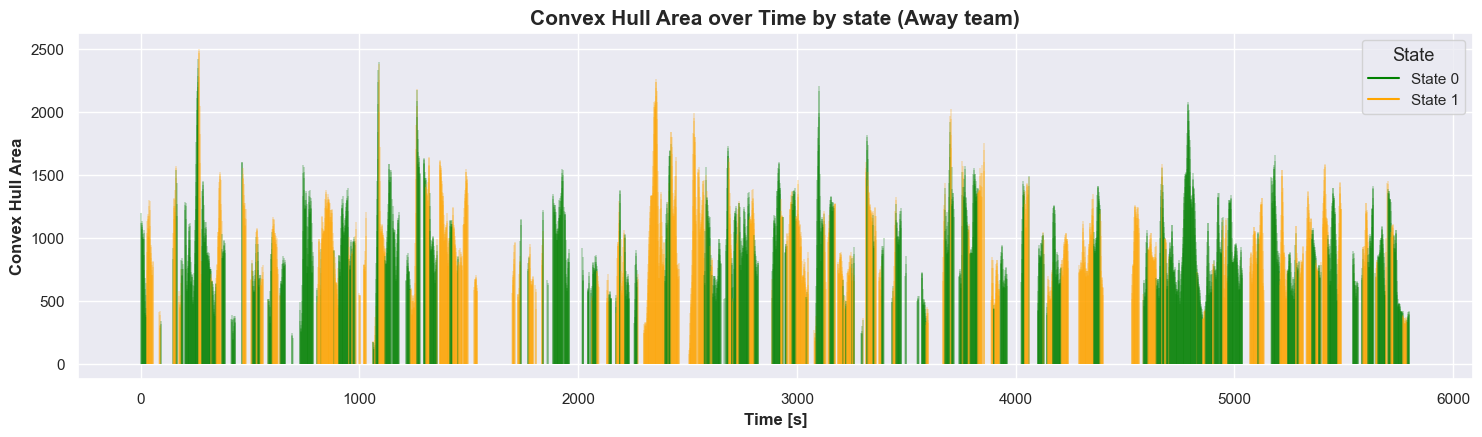

In [38]:
class_colors = {
    0: 'green',
    1: 'orange'
}
colors = data['AwayMLS'].map(class_colors)

plt.figure(figsize=(18, 4.5))
plt.vlines(data["Time [s]"], ymin=0, ymax=data["AwayHull"], color=colors,linewidth=0.3)
plt.xlabel("Time [s]", fontsize=12, fontweight='bold');
plt.ylabel("Convex Hull Area", fontsize=12, fontweight='bold');
plt.title("Convex Hull Area over Time by state (Away team)", fontsize=15, fontweight='bold');

# Creating legend manually since automatic legend does not work well with vlines
for i, state in enumerate([0,1]):
    plt.plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')

plt.legend(title="State", title_fontsize='13', fontsize='11', loc='upper right');
plt.savefig("../plots/UnivariateHMM_MostLikelySeq_AwayTeam_matchday1.png",dpi=350)

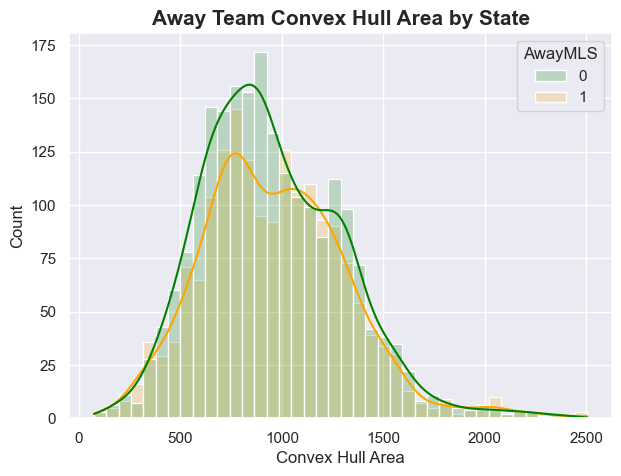

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="AwayHull", hue="AwayMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');
fig.savefig("../plots/UnivariateHMM_StateDistribution_AwayTeam_matchday1.png",dpi=350)

### Bivariate Model

In [30]:
def empirical_gamma_cdf(x, shape, rate):
    # Generate 1000 random samples from the gamma distribution
    # Think about setting a seed to avoid too much stochasticity
    #torch.manual_seed(3407)
    samples = torch.distributions.Gamma(shape, rate).sample((3500,))
    return (samples <= x).float().mean()

def copula_term_log(theta: torch.tensor, u: torch.tensor, v: torch.tensor):
    log_numerator = torch.log(theta) + torch.log(torch.exp(theta) - 1.0) + theta * (1.0 + u + v)
    denominator = (torch.exp(theta) - torch.exp(theta + theta * u) + torch.exp(theta * (u + v)) - torch.exp(theta + theta * v))**2
    log_denominator = torch.log(denominator)
    return log_numerator - log_denominator

def copulamodel_log_pdf(x,y,shape1,rate1,shape2,rate2,theta):
    g1_lpdf= dist.Gamma(shape1,rate1).log_prob(x)
    g2_lpdf= dist.Gamma(shape2,rate2).log_prob(y)
    u= empirical_gamma_cdf(x, shape1, rate1)
    v= empirical_gamma_cdf(y, shape2, rate2)
    # Qui pensare se fare una if su u e v diversi da circa 0...in quel caso non calcolare il copula term (lo lascio nullo)
    if (torch.abs(u) > 1e-6) and (torch.abs(v) > 1e-6):
        copula_term= copula_term_log(theta=theta,u=u,v=v)
        return g1_lpdf+g2_lpdf+copula_term
    else:
        return g1_lpdf+g2_lpdf

In [31]:
def gamma_viterbi_decoder_copula(data, transition_matrix, shape_params1, rate_params1,shape_params2, rate_params2,theta):
    """
    Performs Viterbi decoding for a Gamma HMM.

    Parameters:
    data (list or array): The observations.
    hidden_dim (int): Number of hidden states.
    transition_matrix (torch.Tensor): The state transition probabilities.
    shape_params (torch.Tensor): The shape parameters of the Gamma distributions.
    rate_params (torch.Tensor): The rate parameters of the Gamma distributions.

    Returns:
    list: The most likely sequence of hidden states.
    """
    hidden_dim= transition_matrix.shape[0]
    states = [np.random.randint(low=0,high=hidden_dim)]
    for t in pyro.markov(range(len(data))):
        states.append(pyro.sample("states_{}".format(t),
                                  dist.Categorical(transition_matrix[states[-1]])))
        # pyro.sample("obs_{}".format(t),
        #             dist.Gamma(shape_params[states[-1]], rate_params[states[-1]]),
        #             obs=data[t])
        log_pdf = copulamodel_log_pdf(
            x=data[t,0],
            y=data[t,1],
            shape1=shape_params1[states[-1]],
            rate1=rate_params1[states[-1]],
            shape2=shape_params2[states[-1]],
            rate2=rate_params2[states[-1]],
            theta=theta[states[-1]]
        )
        pyro.factor(f"xy_{t}", log_pdf)
    return states[1:]  # returns the most likely states


Import the data:

In [47]:
xy_sequence = torch.tensor(data[["HomeHull","AwayHull"]].values/100)
xy_sequence.shape

torch.Size([3911, 2])

Import the parametes estimated via Variational Inference:

In [42]:
posterior=torch.load("parameters/doubleHMM_4states.pt")
posterior

{'probs_x': tensor([[0.9447, 0.0132, 0.0153, 0.0268],
         [0.0126, 0.9437, 0.0159, 0.0277],
         [0.0424, 0.0326, 0.9041, 0.0209],
         [0.0644, 0.0625, 0.0411, 0.8321]], requires_grad=True),
 'probs_alpha1': tensor([25.9836, 26.7896,  6.3102, 14.0689], requires_grad=True),
 'probs_beta1': tensor([2.1417, 3.9094, 0.9458, 1.1336], requires_grad=True),
 'probs_alpha2': tensor([20.0916, 22.1323,  7.8966, 14.4246], requires_grad=True),
 'probs_beta2': tensor([2.6456, 1.9161, 1.5289, 1.0799], requires_grad=True),
 'theta': tensor([0.6572, 0.4737, 2.9508, 4.7804], requires_grad=True)}

**Nota**: qui sotto al momento ho inserito a mano i valori...vedere se si riesce a fare in modo più automatico da *posterior*

In [34]:
transition_matrix = posterior["probs_x"]
shape_params1 = posterior["probs_alpha1"]
rate_params1 = posterior["probs_beta1"]
shape_params2 = posterior["probs_alpha2"] 
rate_params2 = posterior["probs_beta2"]
theta= posterior["theta"]


hidden_states = gamma_viterbi_decoder_copula(data=xy_sequence,
                                      transition_matrix=transition_matrix,
                                      shape_params1=shape_params1,
                                      rate_params1=rate_params1,
                                      shape_params2=shape_params2,
                                      rate_params2=rate_params2,
                                      theta=theta
                                      )

Add the most likely sequence for the Home team to our dataframe:

In [51]:
most_likely_states = np.array([int(state) for state in hidden_states])
data["HomeMLS"]=most_likely_states
data["AwayMLS"]=most_likely_states

In [36]:
class_colors = {
    0: 'green',
    1: 'orange',
    2: 'red',
    3: 'blue'
}
colors = data['AwayMLS'].map(class_colors)

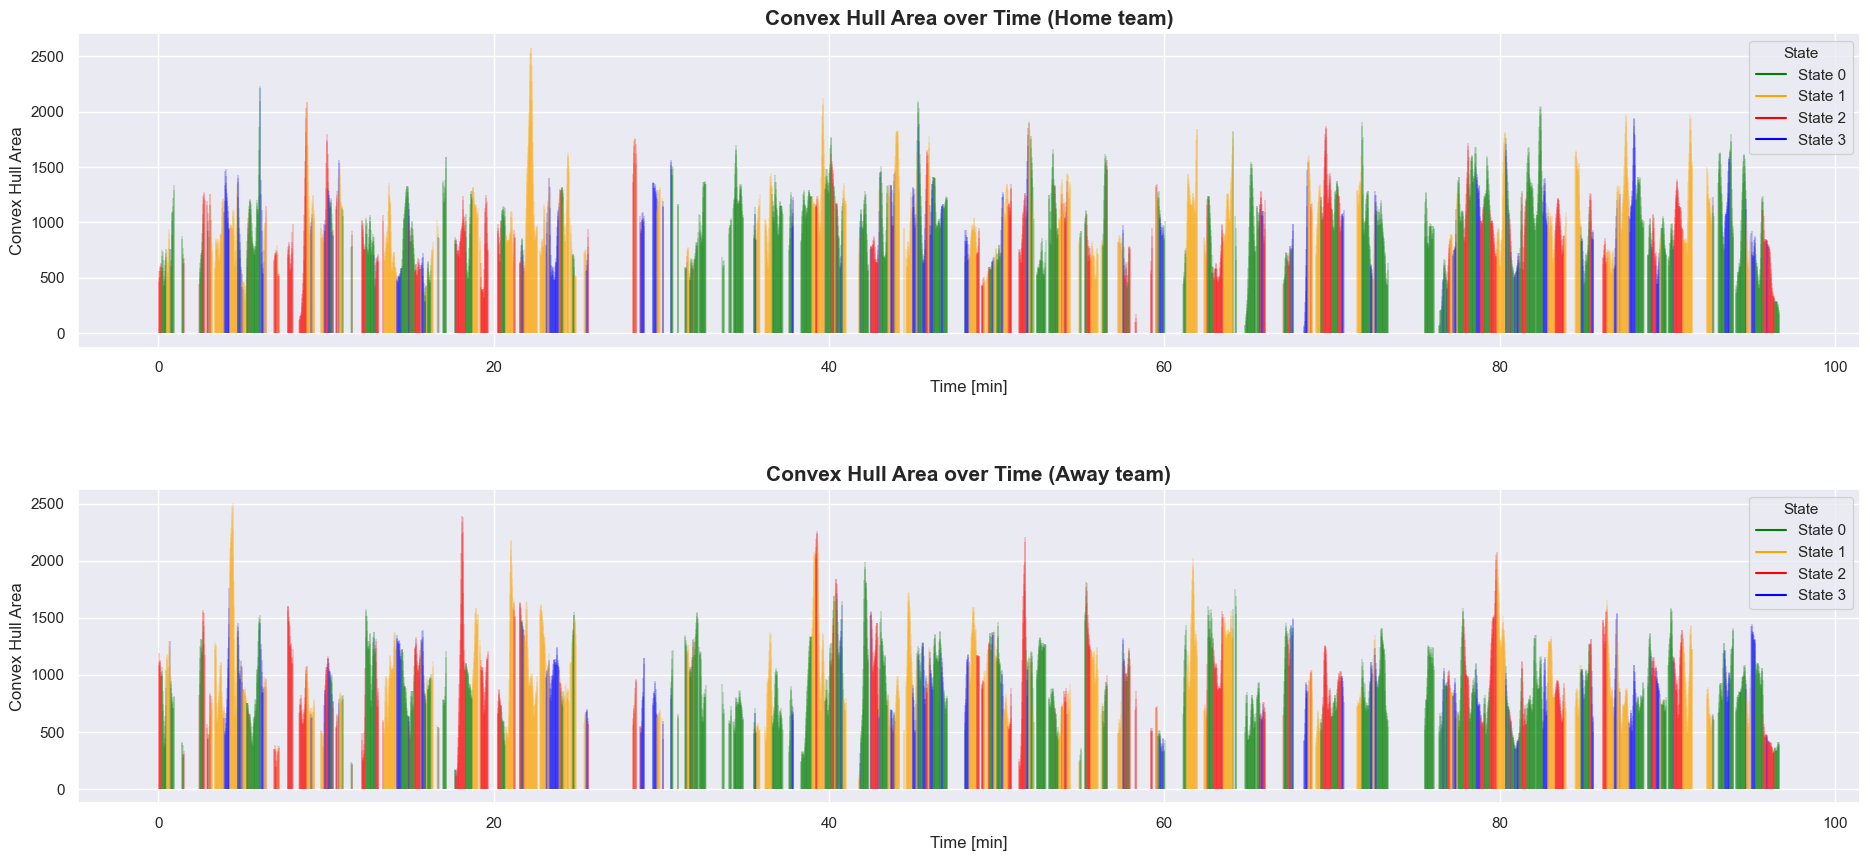

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(23, 10))
# Home team's convex hull area
axs[0].vlines(data["Time [s]"]/60, ymin=0, ymax=data["HomeHull"], color=colors, linewidth=0.25)
axs[0].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[0].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[0].set_title("Convex Hull Area over Time (Home team)", fontsize=15, fontweight='bold');
# add legend
for i, state in enumerate([0,1,2,3]):
    axs[0].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[0].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# Away team's convex hull area
axs[1].vlines(data["Time [s]"]/60, ymin=0, ymax=data["AwayHull"],color=colors, linewidth=0.25)
axs[1].set_xlabel("Time [min]", fontsize=12,fontweight='normal');
axs[1].set_ylabel("Convex Hull Area", fontsize=12, fontweight='normal');
axs[1].set_title("Convex Hull Area over Time (Away team)", fontsize=15, fontweight='bold');
for i, state in enumerate([0,1,2,3]):
    axs[1].plot([], [], color=class_colors[int(state)], label=f'State {int(state)}')
axs[1].legend(title="State", title_fontsize='11', fontsize='11', loc='upper right');

# # add vertical lines for home goals
# for t1,t2 in zip(home_goals["Start Time [s]"],home_goals["End Time [s]"]):
#     axs[0].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2) 
#     axs[1].axvline(x=(t1+t2)/2, color='darkgreen', linestyle='--', linewidth=2)
# # add vertical lines for away goals
# for t1,t2 in zip(away_goals["Start Time [s]"],away_goals["End Time [s]"]):
#     axs[0].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2) 
#     axs[1].axvline(x=(t1+t2)/2, color='black', linestyle='--', linewidth=2)
# Manage space between subplots
plt.subplots_adjust(hspace=0.45)
plt.savefig("../plots/BivariateHMM_MostLikelySeq_matchday1.png",dpi=350, bbox_inches='tight')

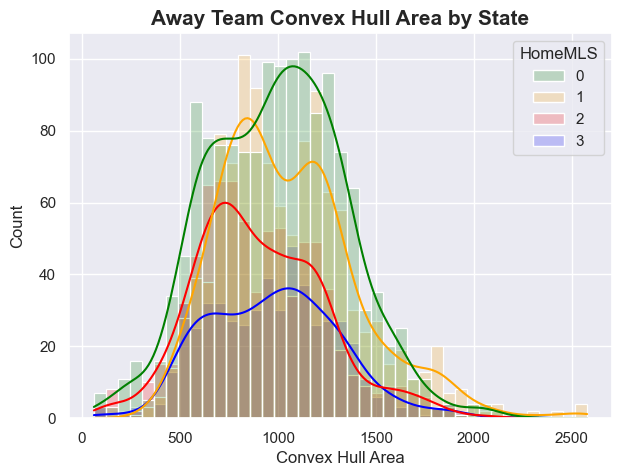

In [52]:
# data["HomeHull"] = data["HomeHull"]
# data["AwayHull"] = data["AwayHull"]
# sns.set_theme(style="darkgrid")

# # Set up the figure
# f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect("equal")

# # Draw a contour plot to represent each bivariate density coloring with class_colors = {
# #     0: 'green',
# #     1: 'orange',
# #     2: 'red',
# #     3: 'blue'
# # }
# #colors = data['AwayMLS'].map(class_colors)

# sns.kdeplot(data=data, x="HomeHull", y="AwayHull", hue="HomeMLS", levels=5, palette=class_colors, linewidths=1.5)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="HomeHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');

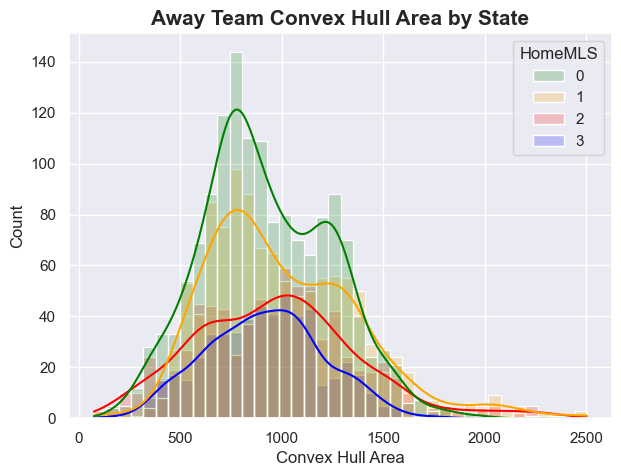

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.histplot(data, x="AwayHull", hue="HomeMLS", kde=True, palette=class_colors,alpha=0.2)
ax.set_xlabel("Convex Hull Area", fontsize=12, fontweight='normal');
ax.set_ylabel("Count", fontsize=12, fontweight='normal');
ax.set_title("Away Team Convex Hull Area by State", fontsize=15, fontweight='bold');